In [1]:
dataset = 'cifar10'
algorithm = 'phate'
n_components = 2

In [2]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


### load packages

In [4]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/umap.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [6]:
from tensorflow.keras.datasets import mnist

In [7]:
from tensorflow.keras.datasets import cifar10

# load dataset
(train_images, Y_train), (test_images, Y_test) = cifar10.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

# flatten X
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
X_valid_flat= X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
print(len(X_train), len(X_valid), len(X_test))

40000 10000 10000


### Create model and train

In [8]:
import phate

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets

X_scaled = MinMaxScaler().fit_transform(X_train_flat)

In [10]:
phate_op = phate.PHATE(n_jobs=-1)
z = data_phate = phate_op.fit_transform(X_scaled)

Calculating PHATE...
  Running PHATE on 40000 observations and 3072 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.92 seconds.
    Calculating KNN search...
    Calculated KNN search in 136.01 seconds.
    Calculating affinities...
    Calculated affinities in 10.26 seconds.
  Calculated graph and diffusion operator in 151.33 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 7.81 seconds.
    Calculating KMeans...
    Calculated KMeans in 75.84 seconds.
  Calculated landmark operator in 85.88 seconds.
  Calculating optimal t...
    Automatically selected t = 25
  Calculated optimal t in 5.39 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.46 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 15.19 seconds.
Calculated PHATE in 259.27 seconds.


### Plot model output

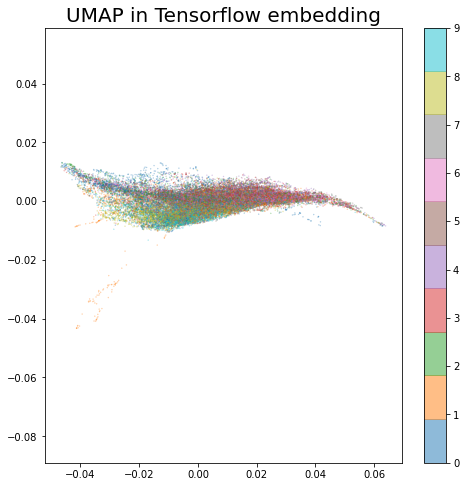

In [11]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### Save output

In [12]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [13]:
output_dir = MODEL_DIR/'projections'/ dataset / algorithm
ensure_dir(output_dir)

In [14]:
#vae.save(output_dir)

In [15]:
#loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [16]:
np.save(output_dir / 'z.npy', z)

### compute metrics 

In [17]:
X_test.shape

(10000, 3072)

In [18]:
z_test = phate_op.transform(X_test)

/home/AD/tsainbur/anaconda3/envs/tfumap/lib/python3.7/site-packages/phate/phate.py:881: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  RuntimeWarning,


Calculating KNN search...
Calculated KNN search in 20.43 seconds.
Calculating affinities...
Calculated affinities in 6.33 seconds.


#### silhouette

In [19]:
from tfumap.silhouette import silhouette_score_block

In [20]:
ss, sil_samp = silhouette_score_block(z, Y_train, n_jobs = -1)
ss

-0.157340505454996

In [21]:
ss_test, sil_samp_test = silhouette_score_block(z_test, Y_test, n_jobs = -1)
ss_test

-0.16280097732558002

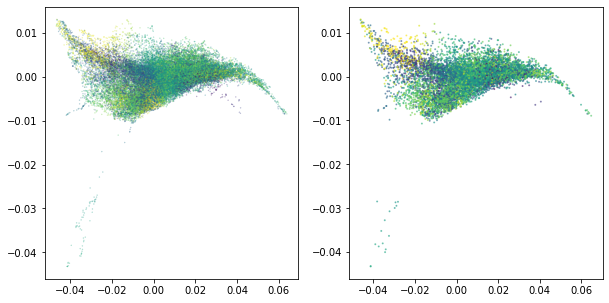

In [22]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=sil_samp, cmap=plt.cm.viridis)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=sil_samp_test, cmap=plt.cm.viridis)

#### KNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(z, Y_train)
score_5nn = neigh5.score(z_test, Y_test)
score_5nn

/home/AD/tsainbur/anaconda3/envs/tfumap/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.1815

In [25]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(z, Y_train)
score_1nn = neigh1.score(z_test, Y_test)
score_1nn

/home/AD/tsainbur/anaconda3/envs/tfumap/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.1599

#### Trustworthiness

In [26]:
from sklearn.manifold import trustworthiness

In [27]:
tw = trustworthiness(X_train_flat[:10000], z[:10000])

In [28]:
tw_test = trustworthiness(X_test_flat[:10000], z_test[:10000])

In [29]:
tw, tw_test

(0.8136919875900721, 0.8111405844675741)

### Save output metrics

In [30]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

#### train

In [31]:
metrics_df = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df.loc[len(metrics_df)] = [dataset, algorithm, n_components, tw, ss, sil_samp]
metrics_df

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
0,cifar10,phate,2,0.813692,-0.157341,"[0.02436960465178962, 0.13600009584875034, -0...."


In [32]:
save_loc = DATA_DIR / 'projection_metrics' /  algorithm / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

#### test

In [33]:
metrics_df_test = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df_test.loc[len(metrics_df)] = [dataset, algorithm, n_components, tw_test, ss_test, sil_samp_test]
metrics_df_test

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
1,cifar10,phate,2,0.811141,-0.162801,"[-0.17197554862535516, 0.09197207707222581, -0..."


In [34]:
save_loc = DATA_DIR / 'projection_metrics' / algorithm / 'test' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

#### knn 

In [35]:
nn_acc_df = pd.DataFrame(columns = ["method_","dimensions","dataset","1NN_acc","5NN_acc"])
nn_acc_df.loc[len(nn_acc_df)] = [algorithm, n_components, dataset,  score_1nn, score_5nn]
nn_acc_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,phate,2,cifar10,0.1599,0.1815


In [36]:
save_loc = DATA_DIR / 'knn_classifier' / algorithm / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
nn_acc_df.to_pickle(save_loc)

### Compute clustering quality

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure

In [38]:
def get_cluster_metrics(row, n_init=5):
    
    # load cluster information
    save_loc = DATA_DIR / 'clustering_metric_df'/ ('_'.join([row.class_, str(row.dim), row.dataset]) + '.pickle')
    print(save_loc)
    if save_loc.exists() and save_loc.is_file():
        
        cluster_df = pd.read_pickle(save_loc)
        return cluster_df
    
    # make cluster metric dataframe
    cluster_df = pd.DataFrame(
        columns=[
            "dataset",
            "class_",
            "dim",
            "silhouette",
            "homogeneity",
            "completeness",
            "v_measure",
            "init_",
            "n_clusters",
            "model",
        ]
    )
    y = row.train_label
    z = row.train_z
    n_labels = len(np.unique(y))
    for n_clusters in tqdm(np.arange(n_labels - int(n_labels / 2), n_labels + int(n_labels / 2)), leave=False, desc = 'n_clusters'):
        for init_ in tqdm(range(n_init), leave=False, desc='init'):
            kmeans = KMeans(n_clusters=n_clusters, random_state=init_).fit(z)
            clustered_y = kmeans.labels_
            homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(
                np.array(y).flatten(), np.array(clustered_y).flatten()
            )
            ss, _ = silhouette_score_block(z, clustered_y)
            cluster_df.loc[len(cluster_df)] = [
                row.dataset,
                row.class_,
                row.dim,
                ss,
                homogeneity,
                completeness,
                v_measure,
                init_,
                n_clusters,
                kmeans,
            ]
    
     # save cluster df in case this fails somewhere
    ensure_dir(save_loc)
    cluster_df.to_pickle(save_loc)
    return cluster_df

In [39]:
projection_df = pd.DataFrame(columns = ['dataset', 'class_', 'train_z', 'train_label', 'dim'])
projection_df.loc[len(projection_df)] = [dataset, algorithm, z, Y_train, n_components]
projection_df

,dataset,class_,train_z,train_label,dim
0,cifar10,phate,"[[0.022543115877952855, 0.0014120582028503826]...","[[6], [9], [9], [4], [1], [1], [2], [7], [8], ...",2


In [40]:
get_cluster_metrics(projection_df.iloc[0], n_init=5)

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/data/clustering_metric_df/phate_2_cifar10.pickle


,dataset,class_,dim,silhouette,homogeneity,completeness,v_measure,init_,n_clusters,model
0,cifar10,phate,2,0.436661,0.040294,0.060861,0.048487,0,5,"KMeans(n_clusters=5, random_state=0)"
1,cifar10,phate,2,0.437108,0.040150,0.060779,0.048357,1,5,"KMeans(n_clusters=5, random_state=1)"
2,cifar10,phate,2,0.437291,0.040241,0.060868,0.048450,2,5,"KMeans(n_clusters=5, random_state=2)"
3,cifar10,phate,2,0.437454,0.040263,0.060930,0.048486,3,5,"KMeans(n_clusters=5, random_state=3)"
4,cifar10,phate,2,0.437336,0.040269,0.060934,0.048492,4,5,"KMeans(n_clusters=5, random_state=4)"
5,cifar10,phate,2,0.416933,0.041582,0.056651,0.047961,0,6,"KMeans(n_clusters=6, random_state=0)"
6,cifar10,phate,2,0.418869,0.041413,0.056766,0.047889,1,6,"KMeans(n_clusters=6, random_state=1)"
7,cifar10,phate,2,0.417899,0.041597,0.057032,0.048107,2,6,"KMeans(n_clusters=6, random_state=2)"
8,cifar10,phate,2,0.416603,0.041768,0.057460,0.048373,3,6,"KMeans(n_clusters=6, random_state=3)"
9,cifar10,phate,2,0.419324,0.041353,0.056588,0.047786,4,6,"KMeans(n_clusters=6, random_state=4)"
